<a href="https://colab.research.google.com/github/BecomeAllan/Bert_meta_learning_papers/blob/main/Meta_learning_EFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [30]:
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0
!pip install -U matplotlib

     |████████████████████████████████| 11.2 MB 5.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import numpy as np
import pandas as pd
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint

SEED = 2222
gen_seed = torch.Generator().manual_seed(SEED)

## Importing data

The 64 topic-agnostic labeled datasets proposed can be downloaded and mounted below:

In [2]:
!wget -O data.zip https://www.dropbox.com/sh/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea?dl=0
!unzip data.zip

--2022-05-16 16:13:43--  https://www.dropbox.com/sh/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea [following]
--2022-05-16 16:13:44--  https://www.dropbox.com/sh/raw/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucea6ad114fb6bb746021db5d11f.dl.dropboxusercontent.com/zip_download_get/BIwkkT2DnIZKdfLe6IGOLHsS7F2yz2z1Ep120QRN4tHkfwJtfzJv7YfNqykBAeRhto2wwep9jfzAu8f8GIf87TDdrWoGCNzy5z-KtH-QJCv4Uw# [following]
--2022-05-16 16:13:45--  https://ucea6ad114fb6bb746021db5d11f.dl.dropboxusercontent.com/zip_download_get/BIwkkT2DnIZKdfLe6IGOLHsS7F2yz2z1Ep120QRN4tHkfwJtfzJv7YfNqykBAeRhto2wwep9jfzAu8f8

In [3]:
import glob
import os

path = 'SLR_data'
paths = glob.glob(f"{path}/**/*.csv", recursive=True)
pprint(paths)

names = [os.path.basename(p) for p in paths]

['SLR_data/SWIFT systematic review data/Fluoride.csv',
 'SLR_data/SWIFT systematic review data/BPA.csv',
 'SLR_data/SWIFT systematic review data/Neuropain.csv',
 'SLR_data/SWIFT systematic review data/Transgenerational.csv',
 'SLR_data/SWIFT systematic review data/PFOS-PFOA.csv',
 'SLR_data/asreview/Wolters_2018.csv',
 'SLR_data/asreview/Hall_2012.csv',
 'SLR_data/asreview/Kitchenham_2010.csv',
 'SLR_data/asreview/van_Dis_2020.csv',
 'SLR_data/asreview/Kwok_2020.csv',
 'SLR_data/asreview/Radjenovic_2013.csv',
 'SLR_data/asreview/Nagtegaal_2019.csv',
 'SLR_data/asreview/Bos_2018.csv',
 'SLR_data/asreview/van_de_Schoot_2017.csv',
 'SLR_data/asreview/Appenzeller-Herzog_2020.csv',
 'SLR_data/asreview/Bannach-Brown_2019.csv',
 'SLR_data/asreview/Wahono_2015.csv',
 'SLR_data/asreview/cohen/SkeletalMuscleRelaxants.csv',
 'SLR_data/asreview/cohen/CalciumChannelBlockers.csv',
 'SLR_data/asreview/cohen/AtypicalAntipsychotics.csv',
 'SLR_data/asreview/cohen/Opiods.csv',
 'SLR_data/asreview/cohen/

Alternatively, import from your Google Drive:

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# import glob
# import os

# path = '/content/drive/MyDrive/SLR_data'
# paths = glob.glob(f"{path}/**/*.csv", recursive=True)

# names = [os.path.basename(p) for p in paths]

In [5]:
# import gdown
# gdown.download_folder("https://drive.google.com/drive/folders/1g8PduqsjTZxnvxnT_Ge_dO-8fLN4blsP?usp=sharing", quiet=True)


## Evaluating text data

In [6]:
#@title Untreated text data { display-mode: "form" }

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
from pprint import pprint
import unicodedata

# Loading data
def handle_data(path):
  data = pd.read_csv(path)
  print()
  sample = data.sample(1)
  text =  sample['abstract'].values[0]
  label = sample['labels'].values[0]
  new_text = unicodedata.normalize("NFKD",str(text))
  print(f"Label = {label}")
  print(f"len(text) = {len(new_text)}")
  pprint(new_text)
  print()
i=0

# Next button
def next_button(p):
  global i
  i=i+1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=len(paths)
    print('End')

# Previous Button
def prev_button(p):
  global i
  i=i-1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=0
    print('End')

next_b = widgets.Button(description="Next")
previous_b = widgets.Button(description="Previous")

hbox = widgets.HBox([previous_b, next_b])
display(hbox)

next_b.on_click(next_button)
previous_b.on_click(prev_button)

In [7]:
#@title Treated text data { display-mode: "form" }

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import unicodedata
import re

# undesirable patterns within texts
patterns = {
    'CONCLUSIONS AND IMPLICATIONS':'',
    'BACKGROUND AND PURPOSE':'',
    'EXPERIMENTAL APPROACH':'',
    'KEY RESULTS AEA':'',
    '©':'',
    '®':'',
    'μ':'',
    '(C)':'',
    'OBJECTIVE:':'',
    'MATERIALS AND METHODS:':'',
    'SIGNIFICANCE:':'',
    'BACKGROUND:':'',
    'RESULTS:':'',
    'METHODS:':'',
    'CONCLUSIONS:':'',
    'AIM:':'',
    'STUDY DESIGN:':'',
    'CLINICAL RELEVANCE:':'',
    'CONCLUSION:':'',
    'HYPOTHESIS:':'',
    'CLINICAL RELEVANCE:':'',
    'Questions/Purposes:':'',
    'Introduction:':'',
    'PURPOSE:':'',
    'PATIENTS AND METHODS:':'',
    'FINDINGS:':'',
    'INTERPRETATIONS:':'',
    'FUNDING:':'',
    'PROGRESS:':'',
    'CONTEXT:':'',
    'MEASURES:':'',
    'DESIGN:':'',
    'BACKGROUND AND OBJECTIVES:':'',
    '<p>':'',
    '</p>':'',
    '<<ETX>>':'',
    '+/-':'',
    }
 
patterns = {x.lower():y for x,y in patterns.items()}

def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text) 

# Text processing
def treat_text(text):
  text = unicodedata.normalize("NFKD",str(text))
  text = multiple_replace(patterns,text.lower())
  text = re.sub('(\(.+\))|(\[.+\])|( \d )|(<)|(>)|(- )','', text)
  text = re.sub('( +)',' ', text)
  text = re.sub('(, ,)|(,,)',',', text)
  text = re.sub('(%)|(per cent)',' percent', text)
  return text

def handle_data(path):
  data = pd.read_csv(path)
  # print('Columns:')
  # print(data.columns)
  print()
  sample = data.sample(1)
  text =  sample['abstract'].values[0]
  label = sample['labels'].values[0]
  new_text = treat_text(text)
  print(f"Label = {label}")
  print(f"len(text) = {len(new_text)}")
  pprint(new_text)
  print()

i=0

# Next button
def next_button(p):
  global i
  i=i+1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=len(paths)
    print('End')

# Previous Button
def prev_button(p):
  global i
  i=i-1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=0
    print('End')

next_b = widgets.Button(description="Next")
previous_b = widgets.Button(description="Previous")

hbox = widgets.HBox([previous_b, next_b])
display(hbox)

next_b.on_click(next_button)
previous_b.on_click(prev_button)

## Downloading pre-trained model


In [8]:
# Fetching pre-trained model and tokenizer

class initializer:
  def __init__(self, MODEL_NAME, **config):    
    self.MODEL_NAME = MODEL_NAME

    model = config.get("model")
    tokenizer = config.get("tokenizer")

    # Model
    self.model = model.from_pretrained(MODEL_NAME, 
                                       return_dict=True,
                                       output_attentions = False)
    # Tokenizer
    self.tokenizer = tokenizer.from_pretrained(MODEL_NAME,
                                               do_lower_case = True)

In [9]:
# Model and tokenizer of choice
config = {
    "model": AutoModelForSequenceClassification,
    "tokenizer": AutoTokenizer
     }

# Pre-trained model initializer (uncased sciBERT)
initializer_model = initializer('allenai/scibert_scivocab_uncased', **config)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

# String funtion


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import unicodedata
import re

# Regex multiple replace function
def multiple_replace(dict, text):

  # Building regex from dict keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # Substitution
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text) 

# Undesirable patterns within texts
patterns = {
    'CONCLUSIONS AND IMPLICATIONS':'',
    'BACKGROUND AND PURPOSE':'',
    'EXPERIMENTAL APPROACH':'',
    'KEY RESULTS AEA':'',
    '©':'',
    '®':'',
    'μ':'',
    '(C)':'',
    'OBJECTIVE:':'',
    'MATERIALS AND METHODS:':'',
    'SIGNIFICANCE:':'',
    'BACKGROUND:':'',
    'RESULTS:':'',
    'METHODS:':'',
    'CONCLUSIONS:':'',
    'AIM:':'',
    'STUDY DESIGN:':'',
    'CLINICAL RELEVANCE:':'',
    'CONCLUSION:':'',
    'HYPOTHESIS:':'',
    'CLINICAL RELEVANCE:':'',
    'Questions/Purposes:':'',
    'Introduction:':'',
    'PURPOSE:':'',
    'PATIENTS AND METHODS:':'',
    'FINDINGS:':'',
    'INTERPRETATIONS:':'',
    'FUNDING:':'',
    'PROGRESS:':'',
    'CONTEXT:':'',
    'MEASURES:':'',
    'DESIGN:':'',
    'BACKGROUND AND OBJECTIVES:':'',
    '<p>':'',
    '</p>':'',
    '<<ETX>>':'',
    '+/-':'',
    }
 
patterns = {x.lower():y for x,y in patterns.items()}

# Model Definition

In [11]:
# Pre-trained model
class Encoder(nn.Module):
  def __init__(self, layers, freeze_bert, model):
    super(Encoder, self).__init__()

    # Dummy Parameter
    self.dummy_param = nn.Parameter(torch.empty(0))
    
    # Pre-trained model
    self.model = deepcopy(model)

    # Freezing bert parameters
    if freeze_bert:
      for param in self.model.parameters():
        param.requires_grad = freeze_bert

    # Selecting hidden layers of the pre-trained model
    old_model_encoder = self.model.encoder.layer
    new_model_encoder = nn.ModuleList()
    
    for i in layers:
      new_model_encoder.append(old_model_encoder[i])

    self.model.encoder.layer = new_model_encoder
  
  # Feed forward
  def forward(self, **x):
    return self.model(**x)['pooler_output']

# Complete model
class SLR_Classifier(nn.Module):
  def __init__(self, **data):
    super(SLR_Classifier, self).__init__()

    # Dummy Parameter
    self.dummy_param = nn.Parameter(torch.empty(0))

    # Loss function
    # Binary Cross Entropy with logits reduced to mean
    self.loss_fn = nn.BCEWithLogitsLoss(reduction = 'mean', pos_weight=torch.FloatTensor([data.get("pos_weight",  2.5)]))

    # Pre-trained model
    self.Encoder = Encoder(layers = data.get("bert_layers",  range(12)),
                           freeze_bert = data.get("freeze_bert",  False),
                           model = data.get("model"),
                           )

    # Feature Map Layer
    self.feature_map = nn.Sequential(
            # nn.LayerNorm(self.Encoder.model.config.hidden_size),
            nn.BatchNorm1d(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            nn.Linear(self.Encoder.model.config.hidden_size, 200),
            nn.Dropout(data.get("drop", 0.5)),
        )

    # Classifier Layer
    self.classifier = nn.Sequential(
            # nn.LayerNorm(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            # nn.BatchNorm1d(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            nn.Tanh(),
            nn.Linear(200, 1)
        )

    # Initializing layer parameters
    nn.init.normal_(self.feature_map[1].weight, mean=0, std=0.00001)
    nn.init.zeros_(self.feature_map[1].bias)

  # Feed forward
  def forward(self, input_ids, attention_mask, token_type_ids, labels):
    
    predict = self.Encoder(**{"input_ids":input_ids,
                              "attention_mask":attention_mask,
                              "token_type_ids":token_type_ids})
    feature = self.feature_map(predict)
    logit = self.classifier(feature)

    predict = torch.sigmoid(logit)
    
    # Loss function 
    loss = self.loss_fn(logit.to(torch.float), labels.to(torch.float).unsqueeze(1))

    return [loss, [feature, logit], predict]

# Meta-Learning phase

Functions based on the repository: https://github.com/mailong25/meta-learning-bert

## Data

### Data Processing

In [12]:
# Loading dataset statistics
def load_data_statistics(paths):
  size = []
  pos = []
  neg = []
  for p in paths:
    data = pd.read_csv(p) 
    data = data.dropna()
    # Dataset size
    size.append(len(data))
    # Number of positive labels
    pos.append(data['labels'].value_counts()[1])
    # Number of negative labels
    neg.append(data['labels'].value_counts()[0])
  del data

  info_load = pd.DataFrame({
      "size":size,
      "pos":pos,
      "neg":neg,
      "names":names,
      "paths": paths })
  return info_load

# Loading the datasets
def load_data(train_info_load):

  col = ['abstract','title', 'labels', 'domain']

  data_train = pd.DataFrame(columns=col)
  for p in train_info_load['paths']:  
    data_temp = pd.read_csv(p).loc[:, ['labels', 'title', 'abstract']]
    data_temp = pd.read_csv(p).loc[:, ['labels', 'title', 'abstract']]
    data_temp['domain'] = os.path.basename(p)
    data_train = pd.concat([data_train, data_temp])
    
  data_train['text'] = data_train['title'] + data_train['abstract'].replace(np.nan, '')

  return( data_train \
            .replace({"labels":{0:"negative", 1:'positive'}})\
            .rename({"labels":"label"} , axis=1)\
            .loc[ :,("text","domain","label")]
        )

In [13]:
# Loading descriptive statistics
info_load = load_data_statistics(paths)

info_load.head()

,size,pos,neg,names,paths
0,3870,49,3821,Fluoride.csv,SLR_data/SWIFT systematic review data/Fluoride...
1,7093,102,6991,BPA.csv,SLR_data/SWIFT systematic review data/BPA.csv
2,29202,5009,24193,Neuropain.csv,SLR_data/SWIFT systematic review data/Neuropai...
3,46147,606,45541,Transgenerational.csv,SLR_data/SWIFT systematic review data/Transgen...
4,5950,95,5855,PFOS-PFOA.csv,SLR_data/SWIFT systematic review data/PFOS-PFO...


In [14]:
# Defining selection criteria for the training dataset: datasets with over 50 positive and 50 negative labels
select_criteria = (info_load['pos'] >= 50) & (info_load['neg'] >= 50)
print(info_load[select_criteria]['names'] )

1                               BPA.csv
2                         Neuropain.csv
3                 Transgenerational.csv
4                         PFOS-PFOA.csv
6                         Hall_2012.csv
8                      van_Dis_2020.csv
9                         Kwok_2020.csv
11                   Nagtegaal_2019.csv
13               van_de_Schoot_2017.csv
14          Appenzeller-Herzog_2020.csv
15               Bannach-Brown_2019.csv
16                      Wahono_2015.csv
18           CalciumChannelBlockers.csv
19           AtypicalAntipsychotics.csv
21                           NSAIDS.csv
22                          Statins.csv
23                   Antihistamines.csv
24                             ADHD.csv
25             ProtonPumpInhibitors.csv
26                        Estrogens.csv
27                         Triptans.csv
28                    ACEInhibitors.csv
29                     BetaBlockers.csv
30                OralHypoglycemics.csv
31              UrinaryIncontinence.csv


In [15]:
# Defining the training dataset
Train_resource = load_data(
    info_load[select_criteria]
)

Train_resource = Train_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Validation data
conditional = Train_resource['domain'] == "PFOS-PFOA.csv"
valid_tranf = Train_resource[conditional]
Train_resource = Train_resource[~conditional].reset_index().drop("index", axis=1)

In [16]:
# Selecting data with at least 40 words separated by spaces
crit = Train_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Train_resource = Train_resource[crit].reset_index().drop("index", axis=1)

In [17]:
# Data that doesn't fit 50pos/50neg criteria
rest_resource = load_data(
    info_load[~select_criteria]
)

rest_resource = pd.concat([valid_tranf, rest_resource]).reset_index().drop("index", axis=1)

In [18]:
# Defining the testing dataset
Test_resource = rest_resource[rest_resource['domain'].isin(['SR11_Li.csv',
 'SR14_Funakoshi.csv',
 'SR2_Meng.csv',
 'SR6_Wang.csv',
 'SR7_Zhou.csv',
 'SR8_Liu.csv',
 'SR9_Douxfils.csv',
 'Distal_radius_fractures_approach.csv',
 'Hallux_valgus_prognostic.csv',
 'Head_and_neck_cancer_imaging.csv',
 'Obstetric_emergency_training.csv',
 'Pregnancy_medication.csv',
 'Shoulderdystocia_positioning.csv',
 'Shoulderdystocia_recurrence.csv',
 'SR12_Cavender.csv',
 'SR13_Chatterjee.csv',
 'SR1_Yang.csv',
 'SR3_Segelov.csv',
 'SR4_Li.csv',
 'SR5_Lv.csv'])]

Test_resource = Test_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Selecting data with at least 40 words separated by spaces
crit = Test_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Test_resource = Test_resource[crit].reset_index().drop("index", axis=1)

In [19]:
# Defining the validation dataset
Valid_resource = rest_resource[rest_resource['domain'].isin(['PFOS-PFOA.csv',
 'Bos_2018.csv',
 'Wolters_2018.csv',
 'SkeletalMuscleRelaxants.csv',
 'Fluoride.csv',
 'Kitchenham_2010.csv',
 'Radjenovic_2013.csv',
 'Opiods.csv',
 'Leafy_Greens_Future_set.csv',
 'Distal_radius_fractures_closed_reduction.csv',
 'Head_and_neck_cancer_bone.csv',
 'Shoulder_replacement_diagnostic.csv',
 'Shoulder_replacement_surgery.csv',
 'Total_knee_replacement.csv',
 'Vascular_access.csv'])]

Valid_resource =  Valid_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Selecting data with at least 40 words separated by spaces
crit = Valid_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Valid_resource = Valid_resource[crit].reset_index().drop("index", axis=1)

### Training dataset

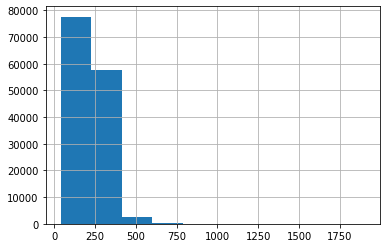

In [27]:
Train_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [28]:
Train_resource.groupby('domain')['label']\
              .value_counts()

domain                             label   
ACEInhibitors.csv                  negative     2041
                                   positive      166
ADHD.csv                           negative      701
                                   positive       80
Antihistamines.csv                 negative      190
                                   positive       87
Appenzeller-Herzog_2020.csv        negative     2182
                                   positive      161
AtypicalAntipsychotics.csv         negative      670
                                   positive      329
BPA.csv                            negative     6980
                                   positive      101
Bannach-Brown_2019.csv             negative     1347
                                   positive      251
BetaBlockers.csv                   negative     1552
                                   positive      267
CalciumChannelBlockers.csv         negative      824
                                   positive      246
Es

### Testing Dataset

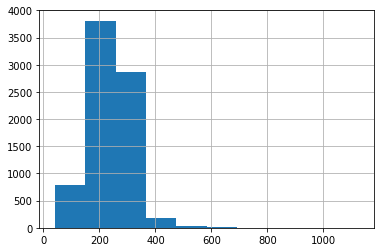

In [29]:
Test_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [30]:
Test_resource.groupby('domain')['label']\
              .value_counts()

domain                                label   
Distal_radius_fractures_approach.csv  negative     170
                                      positive      10
Hallux_valgus_prognostic.csv          negative     595
                                      positive      19
Head_and_neck_cancer_imaging.csv      negative      38
                                      positive      18
Obstetric_emergency_training.csv      negative     152
                                      positive      18
Pregnancy_medication.csv              negative     337
                                      positive      40
SR11_Li.csv                           negative     200
                                      positive       9
SR12_Cavender.csv                     negative     400
                                      positive      14
SR13_Chatterjee.csv                   negative     400
                                      positive      18
SR14_Funakoshi.csv                    negative    1000
                  

### Validation Dataset

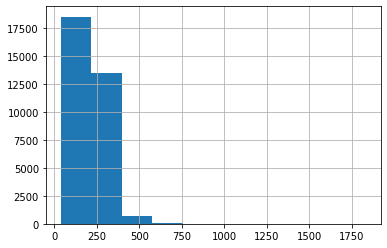

In [31]:
Valid_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [32]:
Valid_resource.groupby('domain')['label']\
              .value_counts()

domain                                        label   
Bos_2018.csv                                  negative    5593
                                              positive      11
Distal_radius_fractures_closed_reduction.csv  negative     244
                                              positive       6
Fluoride.csv                                  negative    3813
                                              positive      49
Head_and_neck_cancer_bone.csv                 negative     266
                                              positive      32
Kitchenham_2010.csv                           negative    1631
                                              positive      45
Leafy_Greens_Future_set.csv                   positive      62
                                              negative      32
Opiods.csv                                    negative    1675
                                              positive      41
PFOS-PFOA.csv                                 negative    5831


## Useful Functions

In [34]:
import os
import torch
import numpy as np
import random
import json, pickle

# Random seed function
def random_seed(value):
    torch.backends.cudnn.deterministic=True
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    np.random.seed(value)
    random.seed(value)

# Batch creation function
def create_batch_of_tasks(taskset, is_shuffle = True, batch_size = 4):
    idxs = list(range(0,len(taskset)))
    if is_shuffle:
        random.shuffle(idxs)
    for i in range(0,len(idxs), batch_size):
        yield [taskset[idxs[i]] for i in range(i, min(i + batch_size,len(taskset)))]


## Tarefas class

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

LABEL_MAP  = {'positive':1, 'negative':0}

# Creating Meta Tasks
class MetaTask(Dataset):
    def __init__(self, examples, num_task, k_support, k_query, tokenizer, training=True, max_seq_length=512, **args):
        """
        :param samples: list of samples
        :param num_task: number of training tasks.
        :param k_support: number of classes support samples per task
        :param k_query: number of classes query sample per task
        """
        self.examples = examples
        
        self.num_task =  num_task
        self.k_support = k_support
        self.k_query = k_query
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        
        # Randomly generating tasks
        self.create_batch(self.num_task, training)
        
    # Creating batch
    def create_batch(self, num_task, training):
        self.supports = []  # support set
        self.queries = []  # query set
        self.task_names = [] # Name of task
        self.supports_indexs = [] # index of supports
        self.queries_indexs = [] # index of queries
        self.num_task=num_task
        
        # Available tasks
        domains = self.examples['domain'].unique()

        # If not training, create all tasks
        if not(training):
          self.task_names = domains
          num_task = len(self.task_names)
          self.num_task=num_task

        
        for b in range(num_task):  # For each task,
            total_per_class = self.k_support + self.k_query 
            task_size = 2*self.k_support + 2*self.k_query 

            # Select a task at random
            if training:  
              domain = random.choice(domains)
              self.task_names.append(domain)
            else:
              domain = self.task_names[b]

            # Task data
            domainExamples = self.examples[self.examples['domain'] == domain]

            # Minimal label quantity
            min_per_class = min(domainExamples['label'].value_counts())

            if total_per_class > min_per_class:
              total_per_class = min_per_class
            
            # Select k_support + k_query task examples
            # Sample (n) from each label(class)
            selected_examples = domainExamples.groupby("label").sample(total_per_class, replace = False)

            # Split data into support (training) and query (testing) sets
            s, q = train_test_split(selected_examples,
                                    stratify= selected_examples["label"],
                                    test_size= 2*self.k_query/task_size,
                                    shuffle=True)
            
            # Permutating data
            s = s.sample(frac=1)  
            q = q.sample(frac=1) 

            # Appending indexes
            if not(training):
              self.supports_indexs.append(s.index)
              self.queries_indexs.append(q.index)

            # Creating list of support (training) and query (testing) tasks
            self.supports.append(s.to_dict('records'))
            self.queries.append(q.to_dict('records'))

    # Creating task tensors
    def create_feature_set(self, examples):
        all_input_ids      = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_attention_mask = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_token_type_ids = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_label_ids      = torch.empty(len(examples), dtype = torch.long)

        for _id, e in enumerate(examples):
          all_input_ids[_id], all_attention_mask[_id], all_token_type_ids[_id], all_label_ids[_id] = self.encode_text(e)

        return TensorDataset(
            all_input_ids,
            all_attention_mask,
            all_token_type_ids,
            all_label_ids
        ) 
      
    # Data encoding
    def encode_text(self, example):
      comment_text = example["text"]
      comment_text = self.treat_text(comment_text)
      labels = LABEL_MAP[example["label"]]

      encoding = self.tokenizer.encode_plus(
        (comment_text, "It is great text"),
        add_special_tokens=True,
        max_length=self.max_seq_length,
        return_token_type_ids=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
      )

      return tuple((
        encoding["input_ids"].flatten(),
        encoding["attention_mask"].flatten(),
        encoding["token_type_ids"].flatten(),
        torch.tensor([torch.tensor(labels).to(int)])
      ))


    # Regex text processing
    def treat_text(self, text):
      text = unicodedata.normalize("NFKD",str(text))
      text = multiple_replace(pattents,text.lower())
      text = re.sub('(\(.+\))|(\[.+\])|( \d )|(<)|(>)|(- )','', text)
      text = re.sub('( +)',' ', text)
      text = re.sub('(, ,)|(,,)',',', text)
      text = re.sub('(%)|(per cent)',' percent', text)
      return text

    # Returns data upon calling
    def __getitem__(self, index):
        support_set = self.create_feature_set(self.supports[index])
        query_set   = self.create_feature_set(self.queries[index])
        name        = self.task_names[index]
        return support_set, query_set, name

    def __len__(self):
        return self.num_task

## Model Meta-Learner

In [ ]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from transformers import BertForSequenceClassification
from copy import deepcopy
import gc
from sklearn.metrics import accuracy_score
import torch
import numpy as np
import torchmetrics
from torchmetrics import functional as fn

class Learner(nn.Module):

    def __init__(self, **args):
        """
        :param args:
        """
        super(Learner, self).__init__()
        
        self.inner_print = args.get('inner_print')
        self.inner_batch_size = args.get('inner_batch_size')
        self.outer_update_lr  = args.get('outer_update_lr')
        self.inner_update_lr  = args.get('inner_update_lr')
        self.inner_update_step = args.get('inner_update_step')
        self.inner_update_step_eval = args.get('inner_update_step_eval')
        self.model = args.get('model')
        self.device = args.get('device')
        
        # Outer optimizer
        self.outer_optimizer = Adam(self.model.parameters(), lr=self.outer_update_lr)
        self.model.train()

    def forward(self, batch_tasks, training = True):
        """
        batch = [(support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset)]
        
        # support = TensorDataset(all_input_ids, all_attention_mask, all_segment_ids, all_label_ids)
        """
        task_accs = []
        task_f1 = []
        task_recall = []
        sum_gradients = []
        num_task = len(batch_tasks)
        num_inner_update_step = self.inner_update_step if training else self.inner_update_step_eval

        # Outer loop tasks 
        for task_id, task in enumerate(batch_tasks):
            support = task[0]
            query   = task[1]
            name   = task[2]
            
            # Copying model
            fast_model = deepcopy(self.model)
            fast_model.to(self.device)
            
            # Inner trainer optimizer
            inner_optimizer = Adam(fast_model.parameters(), lr=self.inner_update_lr)
            
            # Creating training data loaders
            if len(support) % self.inner_batch_size == 1 :
              support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                              batch_size=self.inner_batch_size,
                                              drop_last=True)
            else:
              support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                              batch_size=self.inner_batch_size,
                                              drop_last=False)
                            
            # steps_per_epoch=len(support) // self.inner_batch_size
            # total_training_steps = steps_per_epoch * 5
            # warmup_steps = total_training_steps // 3
            #            

            # scheduler = get_linear_schedule_with_warmup(
            #            inner_optimizer, 
            #           num_warmup_steps=warmup_steps,
            #           num_training_steps=total_training_steps
            #           )

            fast_model.train()            

            # Inner loop training epoch (support set)
            print('----Task',task_id,":", name, '----')
            for i in range(0, num_inner_update_step):
                all_loss = []

                # Inner loop training batch (support set)
                for inner_step, batch in enumerate(support_dataloader):
                    batch = tuple(t.to(self.device) for t in batch)
                    input_ids, attention_mask, token_type_ids, label_id = batch

                    # Feed Foward
                    loss, _, _ = fast_model(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                                  
                    # Computing gradients
                    loss.backward()
                    # torch.nn.utils.clip_grad_norm_(fast_model.parameters(), max_norm=1)
                    
                    # Updating inner training parameters
                    inner_optimizer.step()
                    inner_optimizer.zero_grad()
                    
                    # Appending losses
                    all_loss.append(loss.item())
                    
                    del batch, input_ids, attention_mask, label_id
                    torch.cuda.empty_cache()
                
                if (i+1) % self.inner_print == 0:
                    print("Inner Loss: ", np.mean(all_loss))
            
            fast_model.to(torch.device('cpu'))
            
            # Inner training phase weights
            if training:
                meta_weights = list(self.model.parameters())
                fast_weights = list(fast_model.parameters())

                # Appending gradients
                gradients = []
                for i, (meta_params, fast_params) in enumerate(zip(meta_weights, fast_weights)):
                    gradient = meta_params - fast_params
                    if task_id == 0:
                        sum_gradients.append(gradient)
                    else:
                        sum_gradients[i] += gradient


            # Inner test (query set)
            fast_model.to(self.device)
            fast_model.eval()

            with torch.no_grad():
                # Data loader
                query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
                query_batch = iter(query_dataloader).next()
                query_batch = tuple(t.to(self.device) for t in query_batch)
                q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
                
                # Feed Foward
                _, _, pre_label_id = fast_model(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

                # Predictions
                pre_label_id = pre_label_id.detach().cpu().squeeze()
                # Labels
                q_label_id = q_label_id.detach().cpu()

                # Calculating and appending metrics
                acc = fn.accuracy(pre_label_id, q_label_id).item()
                recall = fn.recall(pre_label_id, q_label_id).item(),
                f1 = fn.f1_score(pre_label_id, q_label_id).item()
                task_accs.append(acc)
                task_f1.append(f1)
                task_recall.append(recall)
            
            fast_model.to(torch.device('cpu'))
            del fast_model, inner_optimizer
            torch.cuda.empty_cache()
        
        print("f1:",np.mean(task_f1))
        print("recall:",np.mean(task_recall))

        # Updating outer training parameters
        if training:
            # Mean of gradients
            for i in range(0,len(sum_gradients)):
                sum_gradients[i] = sum_gradients[i] / float(num_task)

            # Indexing parameters to model
            for i, params in enumerate(self.model.parameters()):
                params.grad = sum_gradients[i]

            # Updating parameters
            self.outer_optimizer.step()
            self.outer_optimizer.zero_grad()
            
            del sum_gradients
            gc.collect()
            torch.cuda.empty_cache()

        return np.mean(task_accs)

## Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Meta-Training informations
Info = {
    "inner_print": 2, 
    "bert_layers": 2,
    "tokenizer": initializer_model.tokenizer,
    "max_seq_length": 512,
    "meta_epoch":30, # Outer loop epochs
    "k_spt":8, # Support (training) examples per class, binary case
    "k_qry":8, # Query (testing) examples per class, binary case
    "outer_batch_size": 5, # Size of batch of tasks
    "inner_batch_size": 4, # Size of batch of classifications
    "outer_update_lr" : 5e-5, # Learning rate of task optimizer
    "inner_update_lr" : 5e-5, # Learning rate of classification optimizer
    "inner_update_step" : 4, # Inner loop epochs
    "inner_update_step_eval": 4, # Validation inner loop epochs
    "num_task_train" : 20, # Number of training tasks
    # "num_task_test" : 5 # Number of testing tasks
    "pos_weight" : 3 # p > 1 increases recall, p < 1 increases precision, applied in loss function
}

model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       model = initializer_model.model.bert,
                       drop=0.2)

learner = Learner(model = model, device   = device, **Info)


torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()

# Testing tasks
test = MetaTask(Test_resource, num_task = 0, k_support=10, k_query=10,
                training=False, **Info)


# Meta-Epoch
for epoch in range(Info['meta_epoch']):
    
    # Training tasks
    train = MetaTask(Train_resource,
                     num_task = Info['num_task_train'],
                     k_support=Info['k_qry'],
                     k_query=Info['k_spt'], **Info)

    # Batch of tasks
    db = create_batch_of_tasks(train, is_shuffle = True, batch_size = Info["outer_batch_size"])

    # Outer loop bach training
    for step, task_batch in enumerate(db):
      
        print("\n-----------------Training Mode","Meta_epoch:", epoch ,"-----------------\n")
        
        # Meta-Feed Foward
        acc = learner(task_batch)
        
        print('Step:', step, '\ttraining Acc:', acc)

        # Validating Model 
        if ((epoch+1) % 4) + step == 0:
            random_seed(123)
            print("\n-----------------Testing Mode-----------------\n")
            db_test = create_batch_of_tasks(test, is_shuffle = False, batch_size = 1)
            acc_all_test = []

            # Looping testing tasks
            for test_batch in db_test:
                acc = learner(test_batch, training = False)
                acc_all_test.append(acc)

            print('Test acc:', np.mean(acc_all_test))
            del acc_all_test, db_test

            # Restarting training randomly
            random_seed(int(time.time() % 10))

torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()


-----------------Training Mode Meta_epoch: 0 -----------------

----Task 0 : OralHypoglycemics.csv ----
Inner Loss:  1.1944907009601593
Inner Loss:  1.0788997113704681
----Task 1 : van_de_Schoot_2017.csv ----
Inner Loss:  1.1536458730697632
Inner Loss:  1.020497590303421
----Task 2 : Estrogens.csv ----
Inner Loss:  1.1664622575044632
Inner Loss:  1.146291732788086
----Task 3 : ProtonPumpInhibitors.csv ----
Inner Loss:  1.1517954468727112
Inner Loss:  1.13856440782547
----Task 4 : Transgenerational.csv ----
Inner Loss:  1.17305988073349
Inner Loss:  0.7649176120758057
f1: 0.6574077665805816
recall: 0.75
Step: 0 	training Acc: 0.6

-----------------Training Mode Meta_epoch: 0 -----------------

----Task 0 : van_Dis_2020.csv ----
Inner Loss:  1.1969518065452576


KeyboardInterrupt: ignored

# Testing trained model

In [ ]:
Valid_resource.groupby('domain')['label'].value_counts()

domain                                        label   
Bos_2018.csv                                  negative    5593
                                              positive      11
Distal_radius_fractures_closed_reduction.csv  negative     244
                                              positive       6
Fluoride.csv                                  negative    3813
                                              positive      49
Head_and_neck_cancer_bone.csv                 negative     266
                                              positive      32
Kitchenham_2010.csv                           negative    1631
                                              positive      45
Leafy_Greens_Future_set.csv                   positive      62
                                              negative      32
Opiods.csv                                    negative    1675
                                              positive      41
PFOS-PFOA.csv                                 negative    5831


## Task diagnosis

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Initializing model
model_to_finetunning = deepcopy(model)

# Creating validation tasks
valid = MetaTask(Valid_resource,
                 num_task = 500,
                 k_support=10,
                 k_query=20,
                 tokenizer = Info['tokenizer'],
                 training=False)

# Diagnostic dataset
i = valid.task_names =='Opiods.csv'

# Task index
idx = np.array(range(len(i)))[i].item()

# Support (train) e query (test) data
support = valid[idx][0]
query   = valid[idx][1]
name   = valid[idx][2]

print(name)
print(Valid_resource[Valid_resource['domain']== name]['label'].value_counts())
print("k_suport_examples:",len(support))
print("k_query_examples:",len(query))

# Support data loader
support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                batch_size=5)


Opiods.csv
negative    1675
positive      41
Name: label, dtype: int64
k_suport_examples: 20
k_query_examples: 40


### Untrained model

acc: 0.5


<AxesSubplot:>

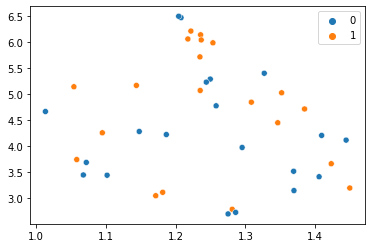

In [ ]:
model_to_finetunning.to(device)

# Inner Optimizer
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)


# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = iter(query_dataloader).next()
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)

# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(features[0].to('cpu'))

# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id)
plt.show()

### Trained model

Inner Loss:  1.1948429942131042
Inner Loss:  0.950939804315567
acc: 0.42500001192092896


<AxesSubplot:>

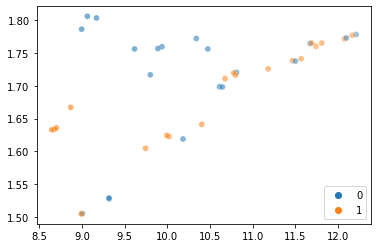

In [ ]:
model_to_finetunning = deepcopy(model)
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)
model_to_finetunning.train()
model_to_finetunning.to(device)

# Inner loop training
for i in range(0,Info['inner_update_step']):
    all_loss = []

    # Inner training batch (support set)
    for inner_step, batch in enumerate(support_dataloader):
        
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        # Feed Foward
        loss, _, _ = model_to_finetunning(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                      
        loss.backward()
        inner_optimizer.step()
        inner_optimizer.zero_grad()
        
        all_loss.append(loss.item())
    
    if i % Info["inner_print"] == 0:
        print("Inner Loss: ", np.mean(all_loss))

# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = iter(query_dataloader).next()
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)



model_to_finetunning.to(torch.device('cpu'))
del  inner_optimizer, model_to_finetunning
torch.cuda.empty_cache()


# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(features[0].to('cpu'))

# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id,
                alpha=torch.sigmoid(features[1]).to('cpu').view(-1))
plt.show()

# Validating Model with valid_resource dataset

In [ ]:
Valid_resource.groupby('domain')['label'].value_counts()

domain                                        label   
Bos_2018.csv                                  negative    5593
                                              positive      11
Distal_radius_fractures_closed_reduction.csv  negative     244
                                              positive       6
Fluoride.csv                                  negative    3813
                                              positive      49
Head_and_neck_cancer_bone.csv                 negative     266
                                              positive      32
Kitchenham_2010.csv                           negative    1631
                                              positive      45
Leafy_Greens_Future_set.csv                   positive      62
                                              negative      32
Opiods.csv                                    negative    1675
                                              positive      41
PFOS-PFOA.csv                                 negative    5831


## Loader class

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

LABEL_MAP = {'negative': 0, 'positive': 1}

class SLR_DataSet(Dataset):
  def __init__(self, **args):
    self.tokenizer = args.get('tokenizer')
    self.data = args.get('data')
    self.max_seq_length = args.get("max_seq_length", 512)
    self.INPUT_NAME = args.get("input", 'x')
    self.LABEL_NAME = args.get("output", 'y')

  # Tokenizing and processing text
  def encode_text(self, example):
    comment_text = example[self.INPUT_NAME]
    comment_text = self.treat_text(comment_text)
    
    labels = LABEL_MAP[example[self.LABEL_NAME]]
    encoding = self.tokenizer.encode_plus(
      (comment_text, "It is great text"),
      add_special_tokens=True,
      max_length=self.max_seq_length,
      return_token_type_ids=True,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    # print(example)
    # print(example[self.LABEL_NAME])
    # print(labels)
    
    return tuple((
      encoding["input_ids"].flatten(),
      encoding["attention_mask"].flatten(),
      encoding["token_type_ids"].flatten(),
      torch.tensor([torch.tensor(labels).to(int)])
    ))
  
  # Text processing function
  def treat_text(self, text):
    text = unicodedata.normalize("NFKD",str(text))
    text = multiple_replace(pattents,text.lower())
    text = re.sub('(\(.+\))|(\[.+\])|( \d )|(<)|(>)|(- )','', text)
    text = re.sub('( +)',' ', text)
    text = re.sub('(, ,)|(,,)',',', text)
    text = re.sub('(%)|(per cent)',' percent', text)
    return text

  def __len__(self):
    return len(self.data)

  # Returning data
  def __getitem__(self, index: int):
    # print(index)
    data_row = self.data.reset_index().iloc[index]
    temp_data =  self.encode_text(data_row)
    return temp_data

## Diagnosis

In [ ]:
# model

# Info = {
#     "inner_print": 1, 
#     "bert_layers": 3,
#     "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
#     # "model": model,
#     "tokenizer": initializer_bert.tokenizer,
#     "max_seq_length": 512,
#     "meta_epoch":30, # Numero de epocas do outerloop
#     "k_spt":20, # Numero de treino por classe (k_spt) caso binario
#     "k_qry":20, # Numero de valicao por classe (k_spt) caso binario
#     "outer_batch_size": 5, # Divide as tasks em batchs tasks
#     "inner_batch_size": 5, # Divide as classificacao em batch de classificao
#     "outer_update_lr" : 5e-5, # Learning rate do otimizador das tasks
#     "inner_update_lr" : 5e-5, # Learning rate do otimizador das classificao
#     "inner_update_step" : 3, # Numero de epocas dentro do inner loop
#     "inner_update_step_eval": 3, # Numero de epocas dentro do inner loop de validacao
#     "num_task_train" : 100, # Quantidade de tarefas de treino
#     "num_task_test" : 5 # Quantidade de tarefas de test
# }

Info["inner_update_step_eval"] = 3
Info["inner_print"] = 1

Useful information:

+ Variables should be specified within `Info`

+ Model should be in the `model` variable

+ Training should be done with specification in the `device` variable

It's possible to access dome of the data from the testing dataset after pressing "Train", such as:

+ `logits`: logits from classifier stage, no activation

+ `X_embedded`: 2-dimensional values from dimensionality reduction of the latent space

+ `features`: Latent space values  (feature_map layer output)

+ `labels`: True values

+ `data_train`: Training data (Not the same order given to the model on training)

+ `data_test`: Testing data

+ `batch_size_test`: Batch size from the testing dataset, so that prediction time can be reduced

In [ ]:
#@title Evaluating validation dataset
batch_size_test =   20 #@param {type:"number"}


from sklearn.metrics import confusion_matrix
from torchmetrics import functional as fn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# WSS function
def wss_calc(p, labels, trsh):
  
  # Prediction based on treshold
  predict_trash = torch.sigmoid(p).squeeze() >= trsh
  CM = confusion_matrix(labels, predict_trash.to(int) )
  tn, fp, fne, tp = CM.ravel()
  recall = tp/(tp+fne)

  # Regular WSS
  wss_old = (tn + fne)/len(labels) -(1- recall)

  tn, fp, fne, tp = CM.ravel()*100 # *100, estabilidade numerica
  P = (tp + fne)  
  N = (tn + fp) 

  # AWSS
  wss_new = (tn/N + fne/P)/(P*N) - (1- recall) + tn/N

  return {
      "wss_o": round(wss_old,4),
      "wss_n": round(wss_new,4),
      "R": round(recall,4),
      "CM": CM
      }

# Task names
names = Valid_resource['domain'].unique()

# Useful names for printing the confusion matrix
col = pd.MultiIndex.from_tuples([
                                   ("Predict", "0"),
                                   ("Predict", "1")
                                   ])
index = pd.MultiIndex.from_tuples([
                                   ("Real", "0"),
                                   ("Real", "1")
                                   ])

i=-1
# Next button
def Next_button(p):
  clear_output()
  global i
  i=i+1

  global domain
  domain = names[i]
  print("Name:", domain)

  global data
  data = Valid_resource[Valid_resource['domain'] == domain]
  print(data['label'].value_counts())

  display(hbox)
  display(next_b)

# Train button
def Train_button(y):
  clear_output()
  print(domain)

  # Preparing data for training
  data_train_loader, data_test_loader = prepare_data(data, valueb.value)

  # Training model
  global logits
  global X_embedded
  global labels
  global features
  logits, X_embedded, labels, features =  train_loop(data_train_loader, data_test_loader)

  tresh_box = widgets.HBox([eval_b, value_trash])
  display(hbox)
  display(tresh_box)
  display(next_b)

# Preparing data for training
def prepare_data(data, n):
  # Splitting train and test data
  global data_train
  data_train = data.groupby('label').sample(n, replace=False)
  idex = data.index.isin(data_train.index)
  global data_test
  data_test = data[~idex].reset_index()
   
  # Iterator for the datasets
  
  ## Train
  data_train_dataset = SLR_DataSet(
    data = data_train.sample(frac=1),
    input = 'text',
    output = 'label',
    **Info)
  
  ## Test
  data_test_dataset = SLR_DataSet(
      data = data_test,
      input = 'text',
      output = 'label',
      **Info)


  # Dataloaders

  ## Train 
  data_train_loader = DataLoader(data_train_dataset,
                                 shuffle=True,
                                 batch_size=Info['inner_batch_size']
                                )

  ## Test
  data_test_loader = DataLoader(data_test_dataset,
                                shuffle =False,
                                batch_size=batch_size_test,
                                drop_last=True
                                )

  return data_train_loader, data_test_loader


# Training loop
def train_loop(data_train_loader, data_test_loader):
  # Initializing model
  model_meta = deepcopy(model)
  optimizer = Adam(model_meta.parameters(), lr=Info['inner_update_lr'])

  model_meta.to(device)
  model_meta.train()

  # Task training loop
  for i in range(0, Info['inner_update_step_eval']):
      all_loss = []

      # Inner training batch (support set)
      for inner_step, batch in enumerate(data_train_loader):
          batch = tuple(t.to(device) for t in batch)
          input_ids, attention_mask,q_token_type_ids, label_id = batch
          
          # Feed Foward
          loss, _, _ = model_meta(input_ids, attention_mask,q_token_type_ids, labels = label_id.squeeze())
          
          # Calculating gradients
          loss.backward()

          # Appending parameters
          optimizer.step()
          optimizer.zero_grad()
          
          all_loss.append(loss.item())
      
      if i % Info['inner_print'] == 0:
          print("Inner Loss: ", np.mean(all_loss))


  # Prediction on testing dataset
  model_meta.eval()
  all_loss = []
  all_acc = []
  features = []
  labels = []
  predi_logit = []

  with torch.no_grad():
      for inner_step, batch in enumerate(data_test_loader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask,q_token_type_ids, label_id = batch

        # Predictions
        _, feature, prediction = model_meta(input_ids, attention_mask,q_token_type_ids, labels = label_id.squeeze())

        prediction = prediction.detach().cpu().squeeze()
        label_id = label_id.detach().cpu()
        logit = feature[1].detach().cpu()
        feature_lat = feature[0].detach().cpu()


        labels.append(label_id.numpy().squeeze())
        features.append(feature_lat.numpy())
        predi_logit.append(logit.numpy())

        acc = fn.accuracy(prediction, label_id).item()
        all_acc.append(acc)
      del input_ids, attention_mask, label_id, batch


  print("acc:", np.mean(all_acc))

  model_meta.to('cpu')
  gc.collect()
  torch.cuda.empty_cache()

  del model_meta, optimizer

  try:
    features = torch.tensor(np.concatenate(np.array(features)))
    labels = torch.tensor(np.concatenate(np.array(labels)))
    logits = torch.tensor(np.concatenate(np.array(predi_logit)))
  except:
    features = torch.tensor(np.array(features))
    labels = torch.tensor(np.array(labels))
    logits = torch.tensor(np.array(predi_logit))

  # TSNE dimensionality reduction
  X_embedded = TSNE(n_components=2, learning_rate='auto',
                    init='random').fit_transform(features)

  return logits, X_embedded, labels, features


# Evaluation button
def Evaluation_button(te):
  clear_output()
  tresh_box = widgets.HBox([eval_b, value_trash])

  print(domain)
  # print("\n")
  print("-------Train data-------")
  print(data_train['label'].value_counts())
  print("-------Test data-------")
  print(data_test['label'].value_counts())
  # print("\n")
  
  display(next_b)
  display(tresh_box)
  display(hbox)

  plot(logits, X_embedded, labels)


# Metrics and graphs
def plot(p, X_embedded, labels):
  tresh = value_trash.value
  
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  fpr, tpr, thresholds = roc_curve(labels, torch.sigmoid(p).squeeze())

  # Not specifying treshold
  # WSS
  ## 0.95 recall
  idx_wss95 = sum(tpr < 0.95)
  wss95_info = wss_calc(p,labels, thresholds[idx_wss95] )
  wss95= f"wss@95:{wss95_info['wss_o']}, R: {wss95_info['R']}"
  print(wss95)
  wss95_adj= f"wss@95_Adj:{wss95_info['wss_n']}"
  print(wss95_adj)

  k = fn.accuracy(torch.sigmoid(p), labels, threshold=thresholds[idx_wss95])
  print('Acc.:', round(k.item(), 4))

  f1 = fn.f1_score(torch.sigmoid(p), labels, threshold=thresholds[idx_wss95])
  print('F1-score:', round(f1.item(), 4))

  # Specifying Treshold
  # Treshold Evaluation
  print(f"Treshold to wss95: {round(thresholds[idx_wss95], 4)}")

  cm = pd.DataFrame(wss95_info['CM'],
             index=index,
             columns=col)
  
  print("\nConfusion matrix:")
  print(cm)

  ## WSS
  print("\n---Metrics with threshold:", tresh, "----\n")
  wss_info = wss_calc(p,labels, tresh )
  wss= f"wss@R:{wss_info['wss_o']}, R: {wss_info['R']}"
  print(wss)
  wss_adj= f"wss@R_Adj:{wss_info['wss_n']}"
  print(wss_adj)

  # Accuracy
  k = fn.accuracy(torch.sigmoid(p), labels, threshold=tresh)
  print('Acc.:', round(k.item(), 4))

  f1 = fn.f1_score(torch.sigmoid(p), labels, threshold=tresh)
  print('F1-score:', round(f1.item(), 4))

  cm = pd.DataFrame(wss_info['CM'],
             index=index,
             columns=col)
  
  print("\nConfusion matrix:")
  print(cm)

  # Graphs

  f, axes = plt.subplots(1, 4, figsize=(25,10))

  alpha = torch.squeeze(torch.sigmoid(p)).numpy()
  
  # print(alpha)

  # plots

  p1 = sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=labels,
                alpha=alpha, ax = axes[0]).set_title('Predictions-TSNE')
  
  t_wss = torch.sigmoid(p) >= thresholds[idx_wss95]
  t_wss = t_wss.squeeze().numpy()

  p2 = sns.scatterplot(x=X_embedded[t_wss, 0],
                y=X_embedded[t_wss, 1],
                hue=labels[t_wss],
                alpha=alpha[t_wss], ax = axes[1]).set_title('WSS@95')

  t = torch.sigmoid(p) >= tresh
  t = t.squeeze().numpy()

  p3 = sns.scatterplot(x=X_embedded[t, 0],
                y=X_embedded[t, 1],
                hue=labels[t],
                alpha=alpha[t], ax = axes[2]).set_title(f'Predictions-Treshold {tresh}')


  roc_auc[1] = auc(fpr, tpr)
  lw = 2

  axes[3].plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1])
  
  axes[3].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  axes[3].axhline(y=0.95, color='r', linestyle='-')
  
  axes[3].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title= "ROC")

  axes[3].legend(loc="lower right")

  plt.show()


# Initializing buttons

value_trash = widgets.FloatText(
    value=0.95,
    description='tresh',
    disabled=False
)

valueb = widgets.IntText(
    value=10,
    description='size',
    disabled=False
)

train_b = widgets.Button(description="Train")
next_b = widgets.Button(description="Next")
eval_b = widgets.Button(description="Evaluation")

hbox = widgets.HBox([train_b, valueb])

clear_output()

display(next_b)

next_b.on_click(Next_button)
train_b.on_click(Train_button)
eval_b.on_click(Evaluation_button)

Button(description='Next', style=ButtonStyle())

In [ ]:
j= data_test[data_test['label'] == 'positive'].index
j= np.random.choice(j)

pprint(data_test['text'].iloc[j])
pprint(data_test.iloc[j])

print("output:",torch.sigmoid(logits[j]))
print("label:", labels[j])

('Graphite nanoparticle addition to fertilizers reduces nitrate leaching in '
 'growth of lettuce (: Lactuca sativa). Nitrogen leaching into groundwater '
 'occurs in nearly all intensively-fertilized agriculture applications and '
 'poses growing environmental and human health risks such as eutrophication '
 'and drinking water contamination. This potential for contamination will '
 'intensify as the population grows. This study focused on nitrate leaching '
 'through soil during the growth of romaine lettuce (Lactuca sativa), a high '
 'value crop in a region (Salinas Valley, CA) suffering from '
 'nitrate-contaminated water. 2-D graphite carbon nanoparticles (CNPs) '
 'produced via an electrochemical exfoliation process, resulting in ∼8 nm '
 'thickness and 250-850 nm width, were combined with fertilizer and applied to '
 'the lettuce in soil to test the CNP effect on yield, nitrate leaching, and '
 'plant nutrient uptake. Greenhouse experiments were conducted under different '
 'nu

$$N= \text{Total}$$
$$R= specificity= {TP \over TP+FN}$$
$$WSS@R = {TN + FN \over N}- (1-R)$$

new?
$$N = \text{Total Negative}$$
$$P = \text{Total Positive}$$

$$WSS={TN/N + FN/P \over N*P}- (1-R)+{TN \over N}$$

$$WSS={TN/N + FN/P \over N*P}- (1-{TP\over P})+{TN \over N}$$

$$WSS={TN\over N^2P} + {FN \over P^2N}- {FN\over P}+{TN \over N}$$

$$WSS={TN\over N}({1\over PN}+1) +{FN\over P}({1\over PN}-1)$$

$$WSS_{new}={TN\over N}-{FN\over P}$$

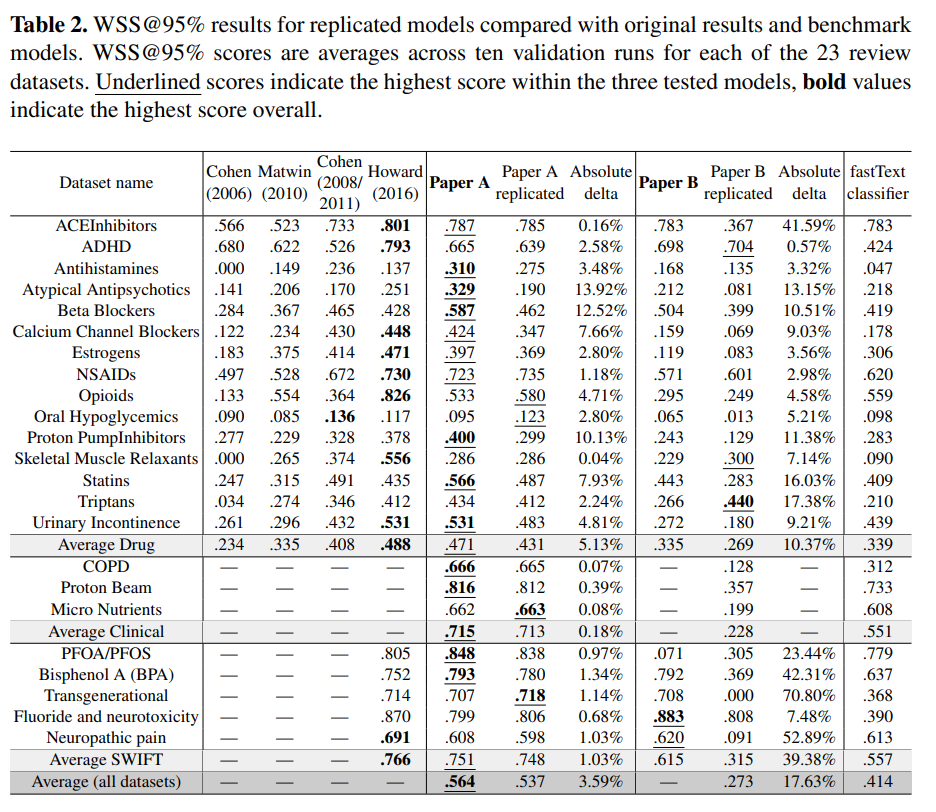

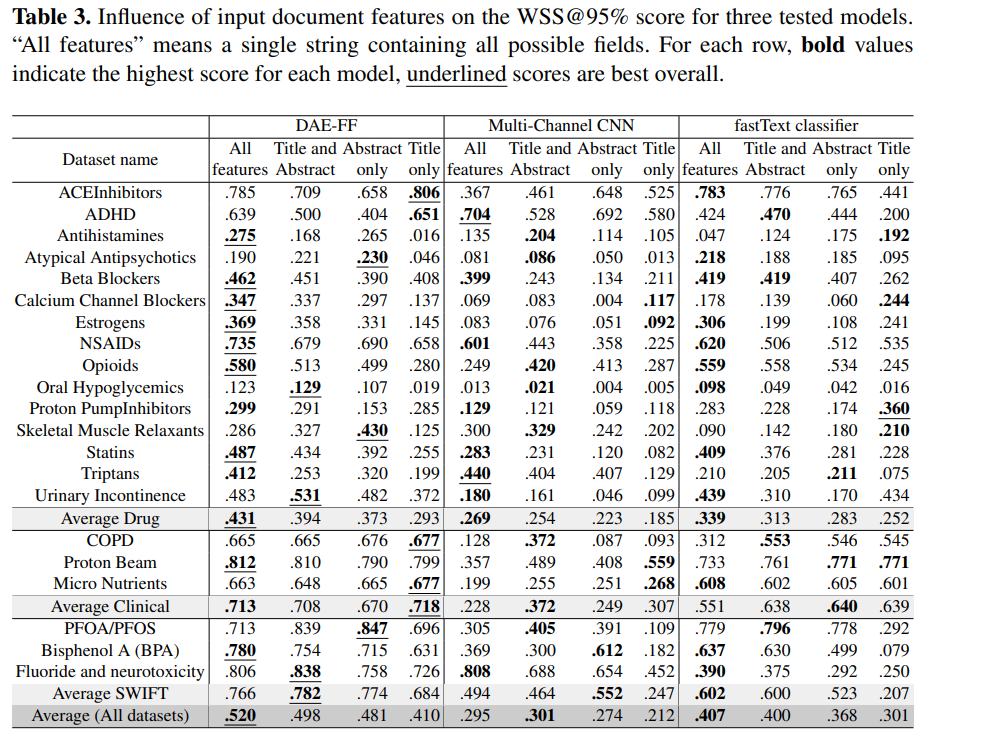

# Save model

In [ ]:
import shutil
import datetime
import re
import json
from pathlib import Path

# Creating directory
Path("./Modelos/Meta-Model").mkdir(parents=True, exist_ok=True)

# Directory data
check = (str(datetime.datetime.now()))[0:19]
check = re.sub("[:-]","_",check)
check = re.sub(" ","_hr_",check)

print("Data e hora do salvamento:", check)

# Creating directory
Path(f"./Modelos/Meta-Model/{check}").mkdir(parents=True, exist_ok=True)

# Saving paths
model_path = f'./Modelos/Meta-Model/{check}/model.pt'
meta_info_path = f'./Modelos/Meta-Model/{check}/Info.json'

# Meta info
save_info = Info.copy()
save_info['model'] = initializer_model.tokenizer.name_or_path
save_info.pop("tokenizer")

## Saving meta info
with open(meta_info_path, 'w') as fp:
    json.dump(save_info, fp)

## Saving entire model
torch.save(model, model_path)

# To save only parameters:
# torch.save(model.state_dict(), model_path)

Data e hora do salvamento: 2022_04_23_hr_02_05_26


# Load model

## Loading entire model

In [ ]:
# Downloading entire model
model = torch.load(model_path)
model

SLR_Classifier(
  (loss_fn): BCEWithLogitsLoss()
  (Encoder): Encoder(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(31090, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

## Loading model weights only

In [ ]:
# import json
# from pprint import pprint

# path1 = 'Modelos/Meta-Model/SLR_checkpoint_train_abstract_2022-04-07'

# with open(path1 + ".json") as meta_info:
#     pprint(json.load(meta_info))


# model1 = SLR_Classifier(bert_layers = range(2),
#                        model = initializer_bert.model,
#                        drop=0.2)

# model1.load_state_dict(torch.load(path1+ ".pt"))


In [ ]:
# import json
# from pprint import pprint

# path2 = 'Modelos/Meta-Model/SLR_checkpoint_train_abstract_2022-04-10 04_09_47.547399'
# meta_path2 = 'Modelos/Meta-Model/SLR_checkpoint_train_abstract_2022-04-10 04_09_47.547491.json'


# with open(meta_path2) as meta_info:
#     pprint(json.load(meta_info))


# model2 = SLR_Classifier(bert_layers = range(2),
#                        model = initializer_bert.model,
#                        drop=0.2)

# model2.load_state_dict(torch.load(path2+ ".pt"))

# Other tests

## MCTI DATA

In [ ]:
# import requests
# import pandas as pd
# url = 'https://github.com/chap0lin/nlp_datasets/blob/master/oportunidades_classificacao_4.xlsx?raw=true'
# r = requests.get(url)
# open('temp.xlsx', 'wb').write(r.content)
# dataMCTI = pd.read_excel('temp.xlsx', sheet_name='Oportunidades')




In [ ]:
# data_train_dataset = SLR_DataSet(
#     data = data_train,
#     input = 'text',
#     output = 'label',
#     **Info)

# print(data_train_dataset[9][2])
# print(data_train.iloc[9,2])

# data_train_loader = DataLoader(data_train_dataset,
#                                           shuffle=True,
#                                           batch_size=Info['inner_batch_size'],
#                                           # drop_last=True
#                                           )


# dataMCTI=dataMCTI.rename({"opo_texto": "text",
#                  "clas": "label"}, axis=1)

## Finetunning - Standard

In [ ]:
# # Configs to download training models
# config = {
#     "model": AutoModelForSequenceClassification,
#     "tokenizer": AutoTokenizer
#      }

# # Pre trained model initializer
# initializer_model = initializer('allenai/scibert_scivocab_uncased', **config)

In [ ]:
# model_meta = SLR_Classifier(bert_layers = range(2), model = initializer_model.model)
# optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)


### Without training

In [ ]:
# model_meta.to("cuda")

# # without training
# model_meta.eval()
# all_loss = []
# all_acc = []
# features = []
# labels = []
# predi_logit = []

# with torch.no_grad():
#     for inner_step, batch in enumerate(data_test_loader):
    
#       batch = tuple(t.to("cuda") for t in batch)
#       input_ids, attention_mask, label_id = batch

#       _, feature, pre_label_id = model_meta(input_ids, attention_mask, labels = label_id.squeeze())


#       pre_label_id = pre_label_id.detach().cpu().squeeze()
#       label_id = label_id.detach().cpu()
#       logit = feature[1].detach().cpu()

#       feature = feature[0].detach().cpu()

#       labels.append(label_id.numpy().squeeze())
#       features.append(feature.numpy())
#       predi_logit.append(logit.numpy())

#       acc = fn.accuracy(pre_label_id, label_id).item()
#       # print("label:",label_id)
#       # print("acc:",acc)
#       all_acc.append(acc)
#       # acc = accuracy_score(pre_label_id, label_id)
#     del input_ids, attention_mask, label_id, batch

# model_meta.to('cpu')
# gc.collect()
# torch.cuda.empty_cache()


# features = np.concatenate(np.array(features))
# labels = np.concatenate(np.array(labels))
# predi_logit = np.concatenate(np.array(predi_logit))


# X_embedded = TSNE(n_components=2, learning_rate='auto',
#                   init='random').fit_transform(features)

# sns.scatterplot(x=X_embedded[:, 0],
#                 y=X_embedded[:, 1],
#                 hue=labels)


### Training

In [ ]:
# model_meta = deepcopy(model)
# optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)

# model_meta.to("cuda")
# model_meta.train()
# for i in range(0,5):
#     all_loss = []

#     # Inner training batch (support set)
#     for inner_step, batch in enumerate(data_train_loader):
        
#         batch = tuple(t.to("cuda") for t in batch)
#         input_ids, attention_mask, label_id = batch
#         loss, _, _ = model_meta(input_ids, attention_mask, labels = label_id.squeeze())
        
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
        
#         all_loss.append(loss.item())
    
#     if i % 4 == 0:
#         print("Inner Loss: ", np.mean(all_loss))



# model_meta.eval()
# all_loss = []
# all_acc = []
# features = []
# labels = []
# predi_logit = []

# with torch.no_grad():
#     for inner_step, batch in enumerate(data_test_loader):
    
#       batch = tuple(t.to("cuda") for t in batch)
#       input_ids, attention_mask, label_id = batch

#       _, feature, pre_label_id = model_meta(input_ids, attention_mask, labels = label_id.squeeze())


#       pre_label_id = pre_label_id.detach().cpu().squeeze()
#       label_id = label_id.detach().cpu()
#       logit = feature[1].detach().cpu()

#       feature = feature[0].detach().cpu()

#       labels.append(label_id.numpy().squeeze())
#       features.append(feature.numpy())
#       predi_logit.append(logit.numpy())

#       acc = fn.accuracy(pre_label_id, label_id).item()
#       # print("label:",label_id)
#       # print("acc:",acc)
#       all_acc.append(acc)
#       # acc = accuracy_score(pre_label_id, label_id)
#     del input_ids, attention_mask, label_id, batch

# model_meta.to('cpu')
# gc.collect()
# torch.cuda.empty_cache()


# features = np.concatenate(np.array(features))
# labels = np.concatenate(np.array(labels))
# predi_logit = np.concatenate(np.array(predi_logit))


# X_embedded = TSNE(n_components=2, learning_rate='auto',
#                   init='random').fit_transform(features)

# sns.scatterplot(x=X_embedded[:, 0],
#                 y=X_embedded[:, 1],
#                 hue=labels)
